# Lab 3, Maria Chernyavskaya, Section AB

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame as df
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy.stats import norm
plt.rcParams["figure.figsize"] = (10,10)

This week we are going to concentrate on asking a statistical question. This process almost always consists of 3+ steps:

1. Writing down in words very precisely what question you are trying to ask.
2. Translating the precise english question into a mathematical expression. This often includes determining the pdf of the background (possibly including trials), and the to integral to do to obtain a probability.
3. Coverting the probability into equivalent sigma

So in this lab we will assume that we know the form of the signal-free background distribution (determining a distribution from data will be next week's lab). In each of our three examples, your task will be to state the statistical question, convert it to math, then perform the associated analyses.

## Problem 1
In our first example we are looking at the temperature reading (meta-data) associated with an experiment. For the experiment to work reliably, the temperature should be at around 12 Kelvin, and if we look at the data it is mostly consistent with 12 Kelvin to within the 0.4 degree precision of the thermometry and the thermal control system (standard deviation). However, there are times when the thermal control system misbehaved and the temperature was not near 12 K, and in addition there are various glitches in the thermometry that give anomalously high and low readings (the reading does not match the real temperature). We definitely want to identify and throw out all the data when the thermal control system was not working (and the temperature was truly off from nominal). While it is possible to have an error in the thermometry such that the true temperature was fine, and we just had a wonky reading, in an abundance of caution we want to throw those values out too.

To make this a bit concrete, we will simulate a little data. Start by simulating 100k 'good' data points assuming Gaussian fluctations, and because we are playing god adding the following 'bad' datapoints: {10., 10.3, 2.1, 0., 0., 15.6, 22.3, 12.7}

### Part A:
So our goal is to identify bad data and throw it out.

1. Start by exploring the data you have created with appropriate plots

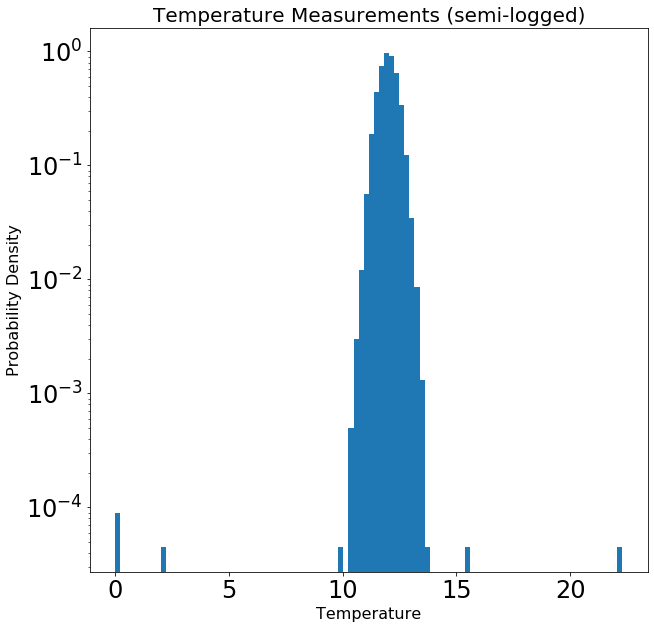

In [2]:
mu = 12
sigma = 0.4
real = stats.norm.rvs(loc = mu, scale = sigma, size = 100000)
fake= [10., 10.3, 2.1, 0., 0., 15.6, 22.3, 12.7]
d = np.append(real, fake)
fig, ax = plt.subplots(1, 1)
ax.hist(d,100, density=True)
plt.tick_params(labelsize = 24)
plt.yscale('log')
plt.xlabel('Temperature', fontsize=16)
plt.ylabel('Probability Density', fontsize=16)
plt.title('Temperature Measurements (semi-logged)', fontsize = 20)
plt.show()

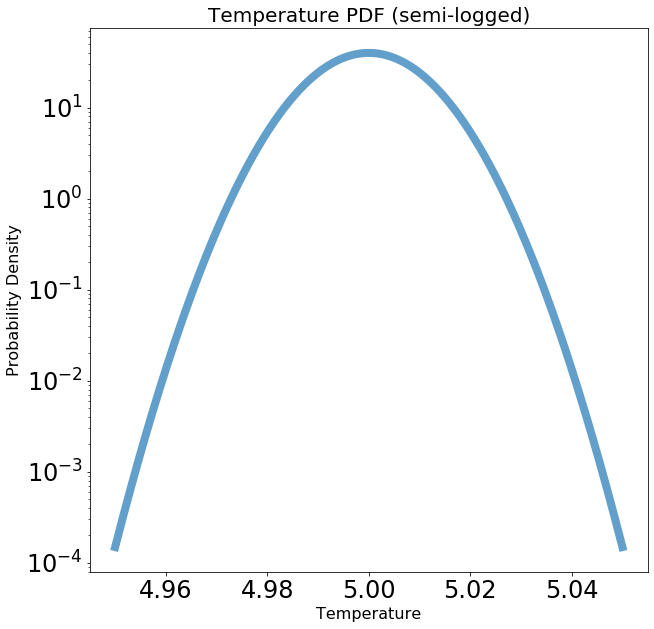

In [3]:
fig, ax = plt.subplots(1, 1)
x = np.linspace(4.95,5.05,1000)
ax.plot(x,stats.norm.pdf(x,loc = 5., scale = 0.01),linewidth = 8,alpha = 0.7)
plt.tick_params(labelsize = 24)
plt.yscale('log')
plt.xlabel('Temperature', fontsize=16)
plt.ylabel('Probability Density', fontsize=16)
plt.title('Temperature PDF (semi-logged)', fontsize = 20)
plt.show();

2. State the statistical question in words. Be very clear, and describe why you have chosen this statistical question.

The statistical question is: what is the probability that a chosen measurement can be correctly identified as truly "bad" or "good"? This question allows me to create a truth table and analyze how well I can sort out the planted "bad" points from what is actually going on in the distribution.

3. Restate your question in math. Be very clear.

I'm going to say that "good" is in between -5 and 5 sigma, and that "bad" is anything outside of that.

In [4]:
np.random.shuffle(d)

100002


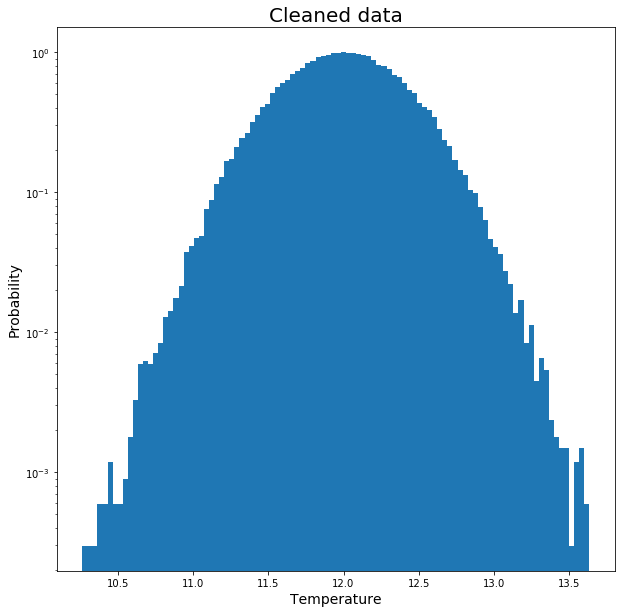

In [5]:
five_away = 1 - stats.norm.cdf(5)

x_top = stats.norm.ppf(1- five_away, mu, sigma)
x_bottom = stats.norm.ppf(five_away, mu, sigma)

for i in reversed(range(len(d))):
    if d[i] > x_top:
        d = np.delete(d, i)
    if d[i] < x_bottom:
        d = np.delete(d, i)
print(len(d))
plt.hist(d, 100, density=True)
plt.yscale('log')
plt.title('Cleaned data', fontsize = 20)
plt.xlabel('Temperature', fontsize = 14)
plt.ylabel('Probability', fontsize=14)
plt.show()

In [6]:
trueNeg = 0
truePos = 0
for i in range(len(real)):
    if real[i] > x_top or real[i] < x_bottom:
        trueNeg += 1
    else:
        truePos += 1
falseNeg = 0
falsePos = 0
for i in range(len(fake)):
    if fake[i] > x_top or fake[i] < x_bottom:
        falseNeg += 1
    else:
        falsePos += 1
            
NN = df({"Data fake":(trueNeg,falseNeg),"Data real":(truePos,falsePos)})
NN = NN.rename(index={0: "Algorithm fake", 1: "Algorithm real"})
NN

,Data fake,Data real
Algorithm fake,0,100000
Algorithm real,6,2


### Part B:
How does the number of omissions, where you threw out good data, depend on the statistical threshold you chose and is it a predictable quantity?

The statistical threshhold determines how likely you are to throw away bad and good data on the edges- if it's related to standard deviations. What I mean is, if I'm throwing away something greater than Xsigma, and my bad data is there, it will be omitted correctly. But if I have good data in that threshhold, it will also be removed. Values close to the mean will not be affected with this kind of algorithm, so a different approach must be used.

### Part C:
Are there mistakes of commission (bad data getting in)? If yes, are they avoidable and how do they depend on your statistical threshold?

Yes! The bad data that's close to average (mu) doesn't go away. I think it can be avoided by using a condition relating to the pdf at a value (like a Dirac delta thing). It can't be sorted through standard deviations though.

## Problem 2
In this example we will be looking for asteroids. If we look at the alignment of stars on subsequent images, they don't perfectly align due to atmospheric and instrumental effects (even ignoring proper motion). The resulting distribution is two dimensional, and for this lab let's assume it is a 2D Gaussian with 1 arcsecond RMS. Or said another way, if I histogram how far all the (stationary) stars appear to have moved I get something like:

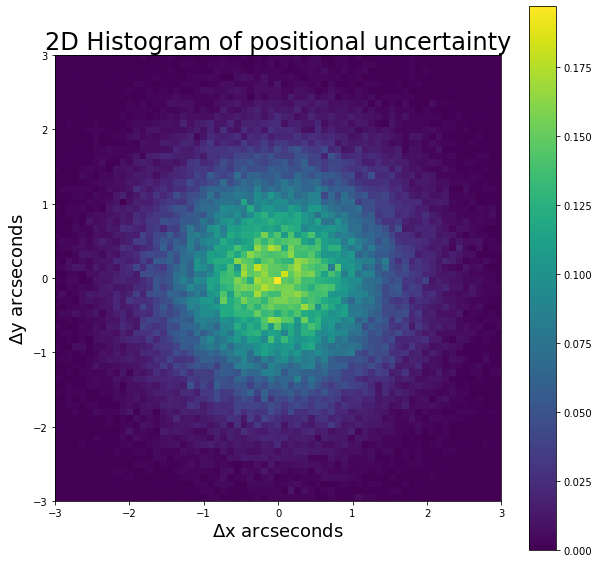

In [7]:
a = np.vstack((stats.norm.rvs( scale = 1, size = 100000), stats.norm.rvs( scale = 1, size = 100000)))
a.shape
fig, ax = plt.subplots(1, 1)
h = ax.hist2d(a[0,:],a[1,:],bins=100, density=True);
ax.set_aspect('equal', 'box')
plt.xlim([-3 , 3])
plt.ylim([-3 , 3])
plt.title("2D Histogram of positional uncertainty", fontsize = 24)
plt.ylabel("$\Delta$y arcseconds", fontsize = 18)
plt.xlabel("$\Delta$x arcseconds", fontsize = 18)
plt.colorbar(h[3], ax=ax);

If I have a potential asteroid, it will have some true movement between the images. We would like a '5 sigma' detection of movement. What is that distance in arcseconds?

1. What is the question in words?

In words, the question is: what distance away from the origin would allow us to confirm a potential object as an asteroid? 

2. What is the question in math? [Hint: Come up with an analytic description of your pdf(). The Blue Book may be helpful here.]

Mathematically, at what distance would a potential asteroid reach 5 sigma away from average and not be considered an asteroid, given a 2D Gaussian with 1 arcsec RMS and sensitivity 5 sigma? This means that I need to find what pdf describes a $R^2 = \sqrt{X^2 + Y^2}$. According to Wikipedia, that would be a Rayleigh distribution. This means I need to find the point that corresponds to 5 sigma away.

3. What distance in arcseconds represents a 5 sigma detection of motion?

In [8]:
five_away = 1 - stats.norm.cdf(5)
point_away = stats.rayleigh.ppf(1 - five_away)
print('5 sigma in Rayleigh distribution is ' + str(point_away) + ' arcseconds.')

5 sigma in Rayleigh distribution is 5.489079776034238 arcseconds.


## Problem 3
As we discussed in class, one of the key backgrounds for gamma-ray telescopes are cosmic rays. Cosmic rays are charged particles—usually protons or electrons but can include atomic nuclei such a alpha particles (helium) or iron. Because of their charge cosmic rays spiral in the magnetic field of the galaxy. From the perspective of the Earth they appear to be coming uniformly from all directions like a high energy gas, and the direction the cosmic ray is travelling when it reaches the Earth tells us nothing about where it came from because we don't know what tortured path it has taken through the galaxy to reach us. However, at trillion electron volt energies and above, the spiral loops are fairly big and the sun and the moon will block cosmic rays. This means the sun and the moon appear as holes in the cosmic ray sky (cosmic rays from that direction are absorbed).

Assume in a moon sized patch on the sky we normally have a cosmic ray rate of 1 cosmic ray per minute (arrivals are random in time). If we can observe where the moon is for 8 hours per night (not too close to the horizon) and we observe for 15 days and see 6800 cosmic rays, what is the signficance of our moon shadow detection?

As always:

1. What is the question in words?
2. Translate the question to math, describing both the expected background pdf() and the integral you need to do.
3. Convert to sigma.

There are some unique aspects to this problem. Make sure you explore them in your explanation.

The unique aspect consists of dealing with discrete probability. We are measuring the number of cosmic rays over time and determining whether or not we get moonshadow based on this. We should use a Poisson Distribution because this distribution deals with the probability of a given number of events occurring within a fixed interval of time where each trial is independent of the last- and that's our situation.

1. Question in words:
"What is the probability that the moon-sized patch we are dealing with actually contains the moon, given that we are observing 6800 cosmic rays in 15 days?" 

2. Question in math: 
The pdf is going to correspond to a Poisson Distribution due to reasons listed above. Poisson needs an average rate for $\lambda$: $1\text{ cosmic ray per minute} * 60 \text{ minutes per hour} * 8\text{ hour per day} * 15\text{ days} = 7200 \text{ cosmic rays}$. Our answer is the sigma corresponding to the probability in a sum of the Poisson pdf from 0 to 6800, given our calculated lambda. Remember that the sigma comes from equating the Poisson distribution to a normal one by null hypothesis theory.

In [9]:
k = 6800
mu = 7200
prob = stats.poisson.cdf(k, mu)
print("Probability of 6800 rays or less: " + str(prob))

sig = stats.norm.ppf(prob)
print("Sigma of 6800: " + str(sig))

Probability of 6800 rays or less: 1.0133280183917768e-06
Sigma of 6800: -4.750747965777188


Recall that our sigma is -4.75 (emphasis on negative) because we were looking for something below 6800, meaning to the left of our mean. The magnitude is still less than 5, which means we cannot claim discovery: there need to be even less gamma rays for us to be confident that the moon is really casting shadow there.